In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from PIL import Image
import os

In [2]:
data = pd.read_csv('recommendation_data.csv')
image_directory = "https://storage.googleapis.com/clozify-data-ml/images/"

In [3]:
def recommend_items_by_sub_category(data, gender, season, emotion_category, top_m=3, top_n=5):
    # Step 1: Group data by subCategory
    sub_categories = data['subCategory'].unique()
    
    recommendations = {}
    
    for category in sub_categories:
        # Filter data for the current subCategory and input attributes
        category_data = data[
            (data['gender'] == gender) &
            (data['season'] == season) &
            (data['Emotion_Category'] == emotion_category) &
            (data['subCategory'] == category)
        ].reset_index(drop=True)
        
        if category_data.empty:
            recommendations[category] = "No items found for this category."
            continue
        
        # Extract embeddings
        embeddings = category_data.loc[:, '0':'2047'].astype(float).values
        
        # Compute similarity
        similarity_matrix = cosine_similarity(embeddings)
        
        # Pick top recommendations for the first few items
        category_recommendations = []
        for idx in range(min(len(category_data), top_m)):
            similarities = similarity_matrix[idx]
            similar_indices = np.argsort(similarities)[::-1][1:top_n + 1]
            category_recommendations.append({
                'recommended_items': category_data.iloc[idx]['image'],
                'more_recommended_items': category_data.iloc[similar_indices]['image'].values.tolist()
            })
        
        recommendations[category] = category_recommendations
    
    return recommendations

In [4]:
# Example usage
recommendations_by_category = recommend_items_by_sub_category(
    data,
    gender='Women',
    season='Rainy',
    emotion_category='Contentment'
)
recommendations_by_category

{'TopWear': [{'recommended_items': '21174.jpg',
   'more_recommended_items': ['21116.jpg',
    '20012.jpg',
    '10340.jpg',
    '58501.jpg',
    '1986.jpg']},
  {'recommended_items': '59404.jpg',
   'more_recommended_items': ['45982.jpg',
    '59405.jpg',
    '21115.jpg',
    '7202.jpg',
    '1991.jpg']},
  {'recommended_items': '21116.jpg',
   'more_recommended_items': ['21174.jpg',
    '1986.jpg',
    '20234.jpg',
    '58501.jpg',
    '1991.jpg']}],
 'Bottomwear': [{'recommended_items': '12155.jpg',
   'more_recommended_items': ['12162.jpg',
    '48097.jpg',
    '14117.jpg',
    '39122.jpg',
    '43523.jpg']},
  {'recommended_items': '23043.jpg',
   'more_recommended_items': ['14117.jpg',
    '12759.jpg',
    '7708.jpg',
    '57824.jpg',
    '12333.jpg']},
  {'recommended_items': '27417.jpg',
   'more_recommended_items': ['10713.jpg',
    '13346.jpg',
    '57212.jpg',
    '57218.jpg',
    '43523.jpg']}],
 'Footwear': [{'recommended_items': '4140.jpg',
   'more_recommended_items': ['

Master Category: TopWear


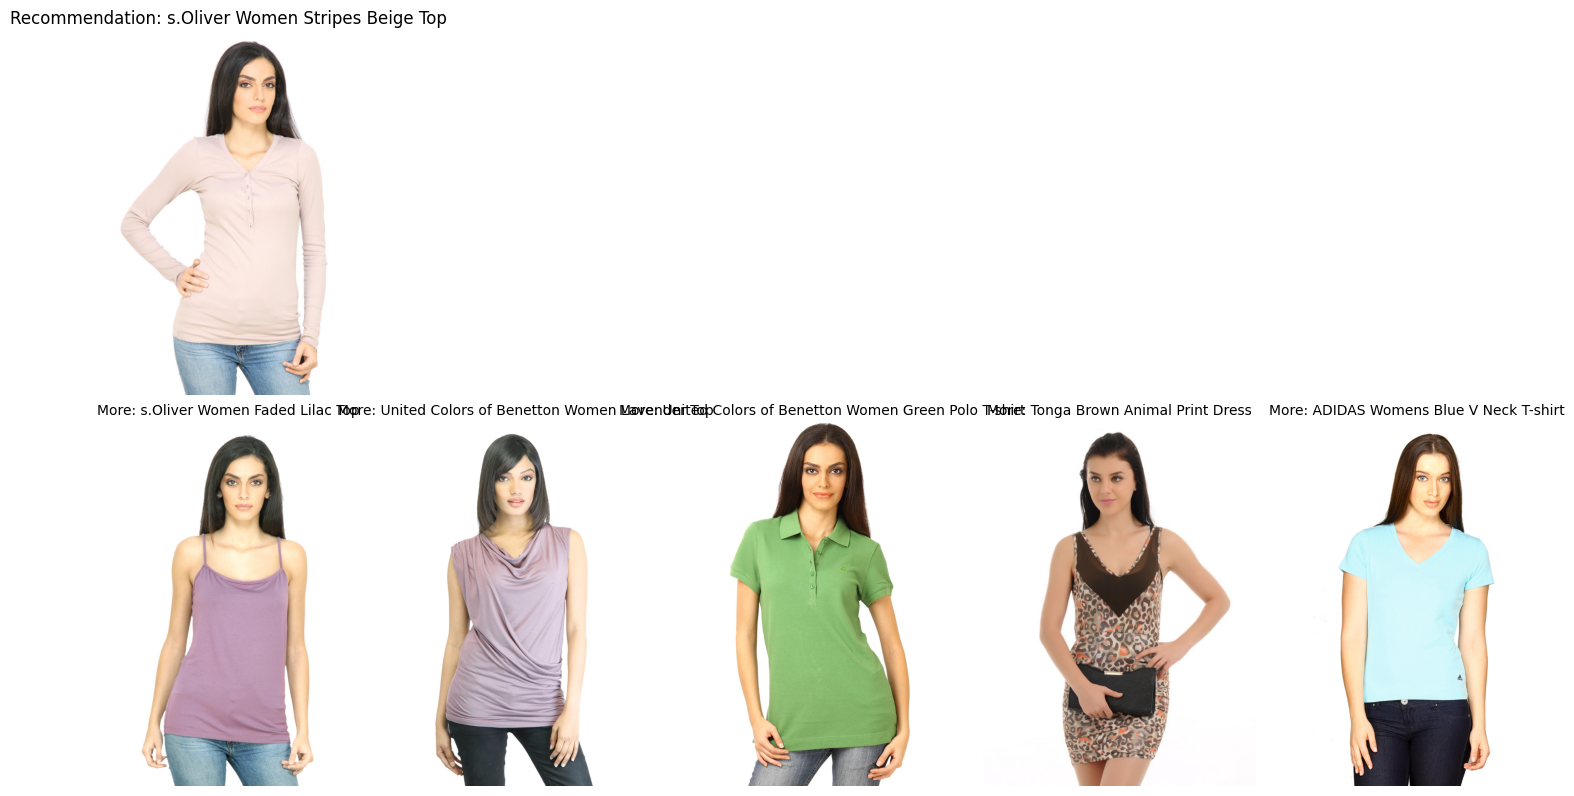

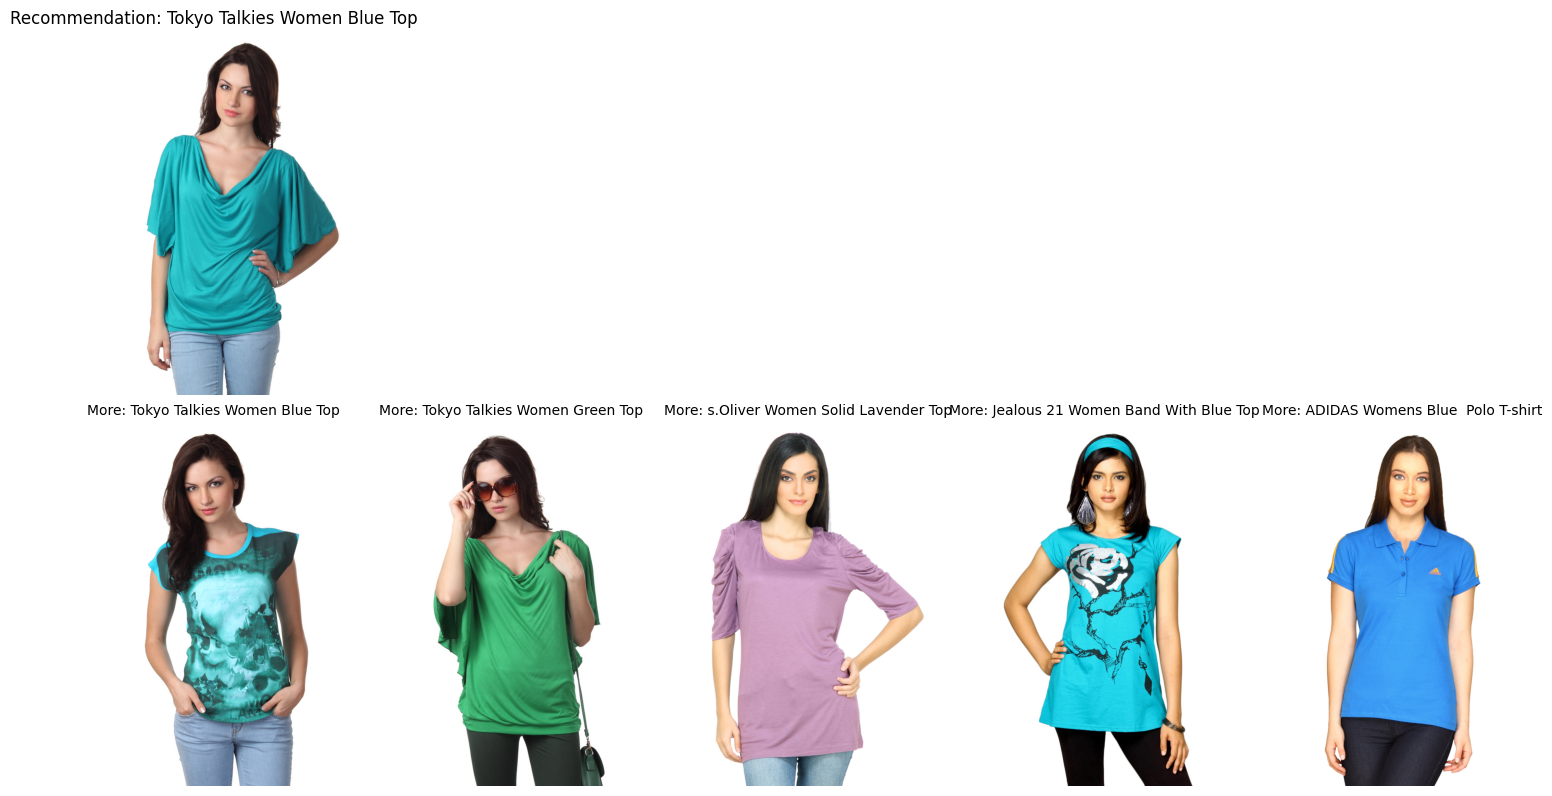

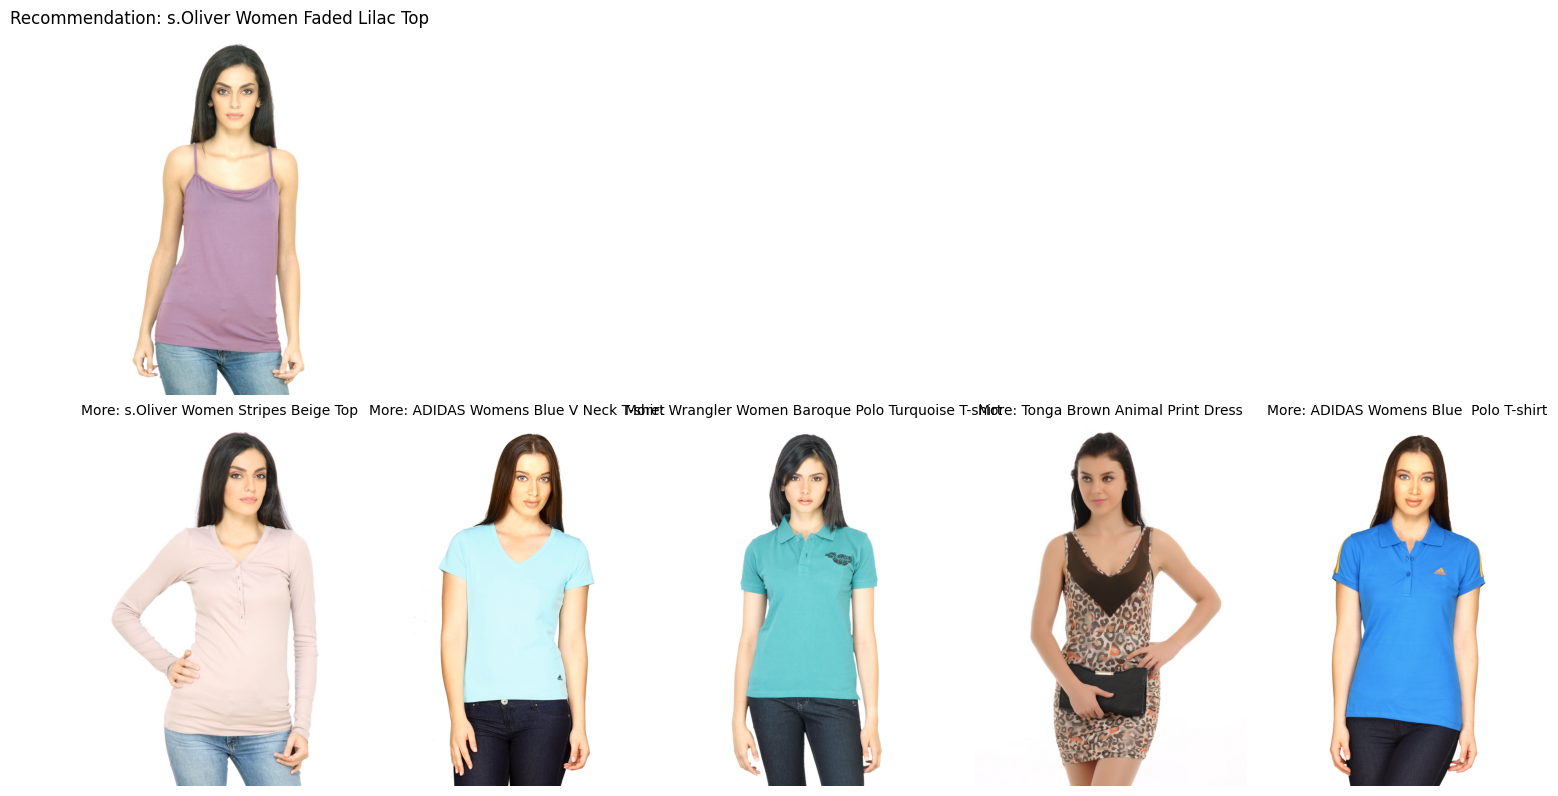

Master Category: Bottomwear


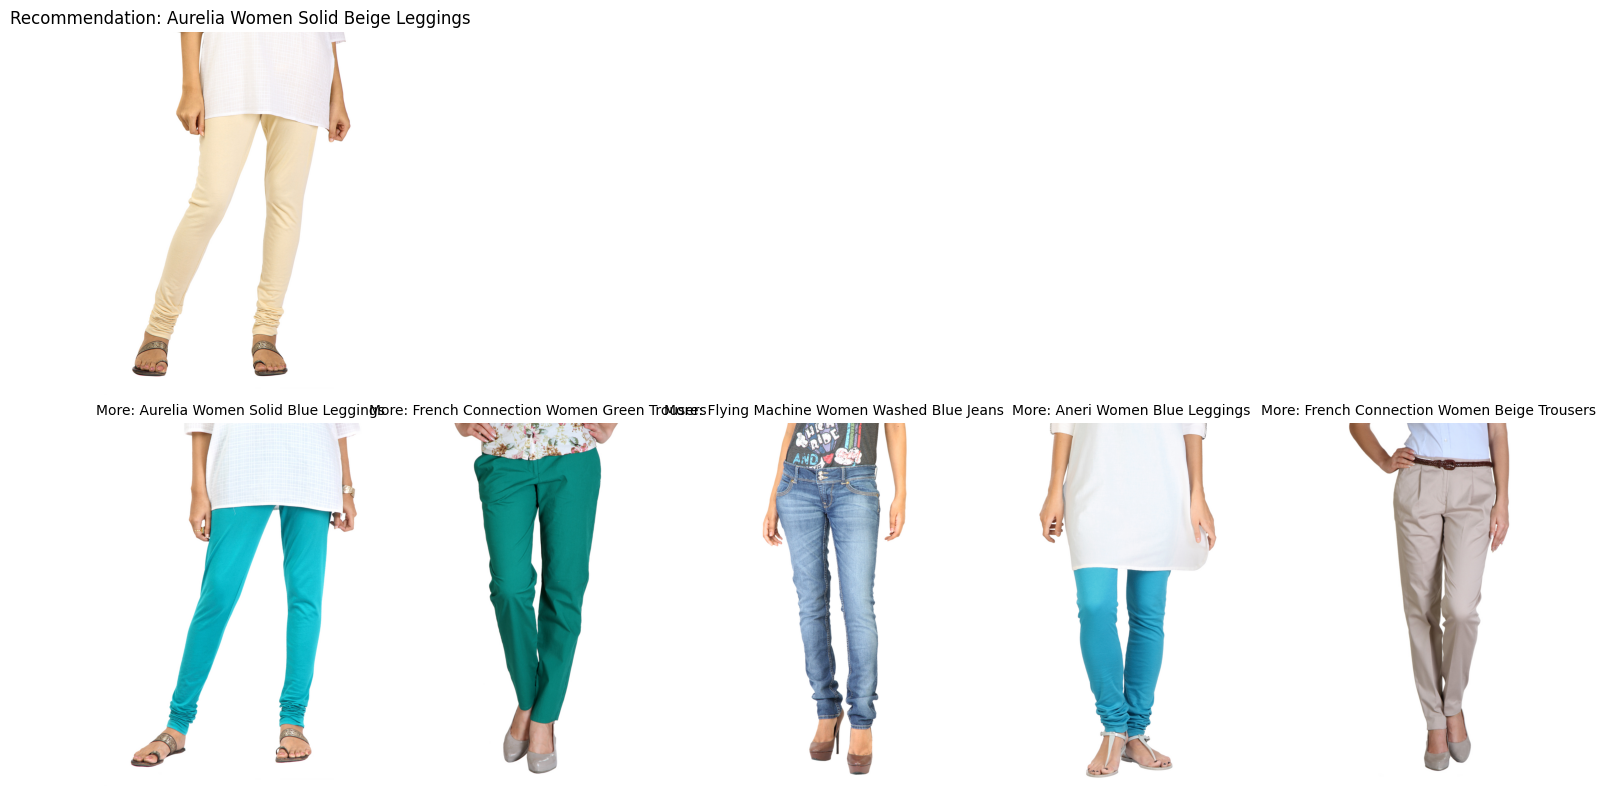

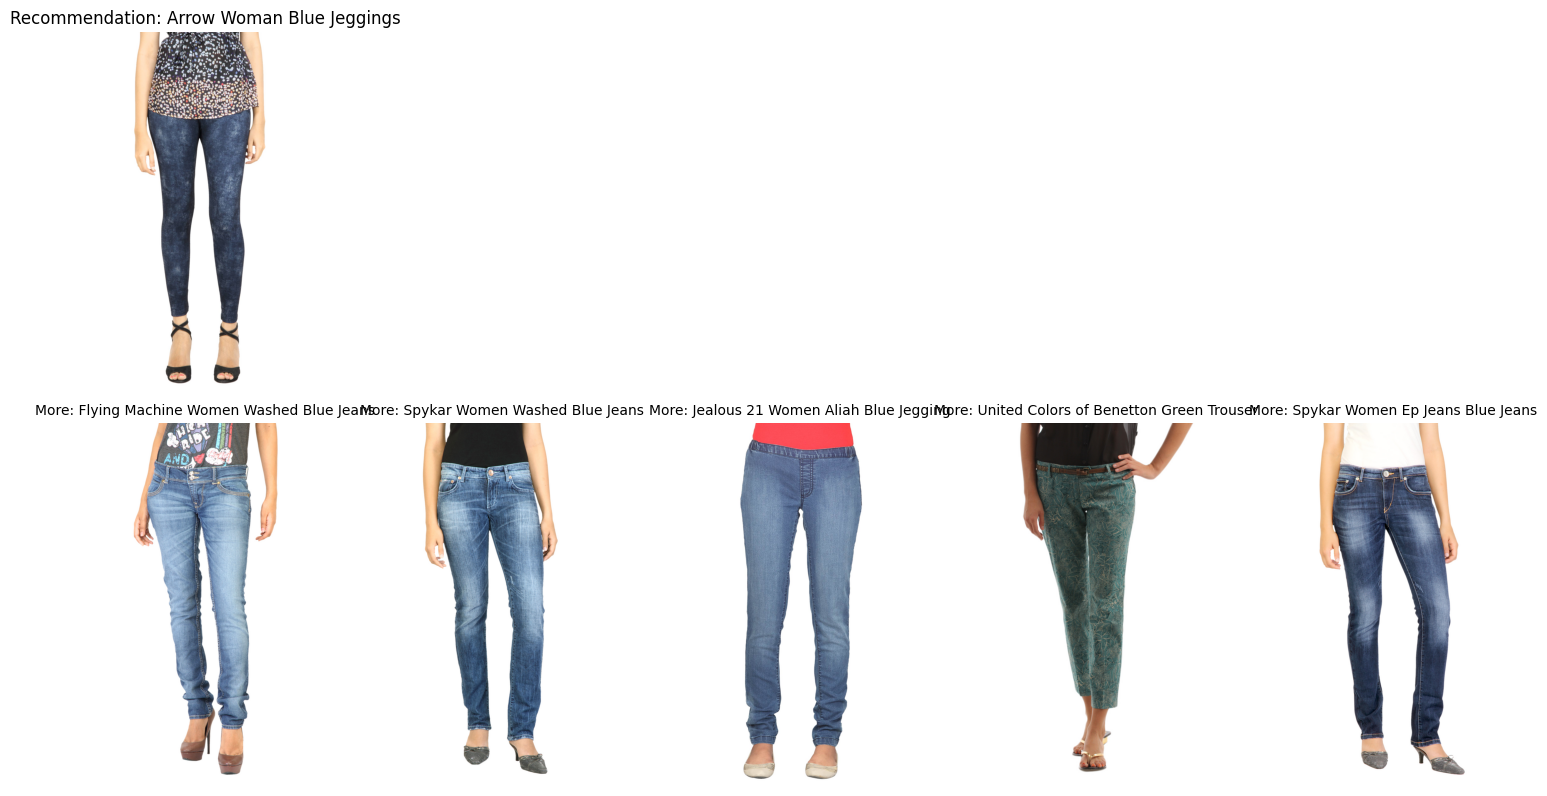

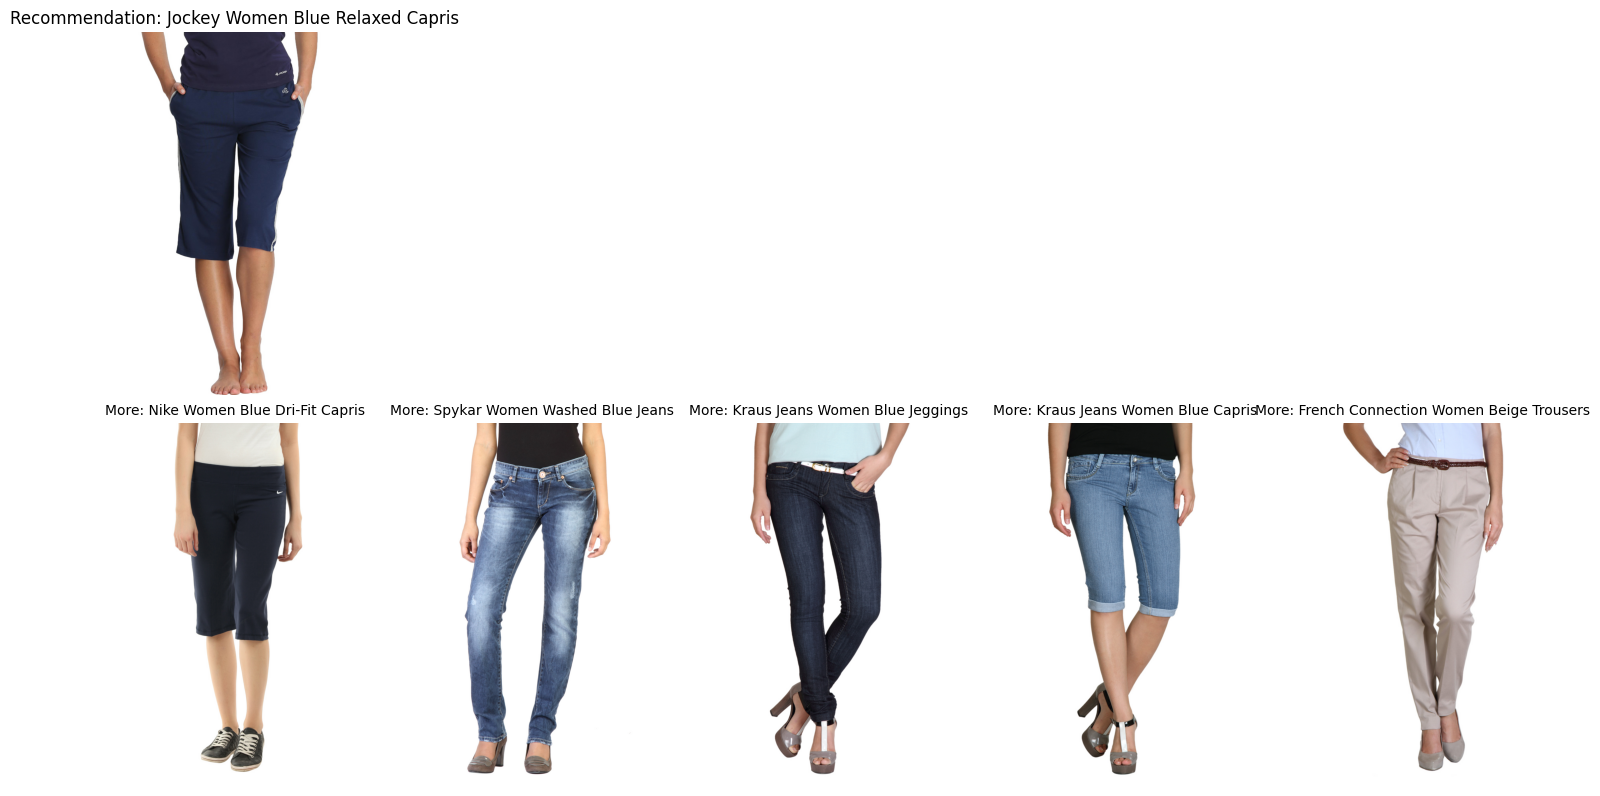

Master Category: Footwear


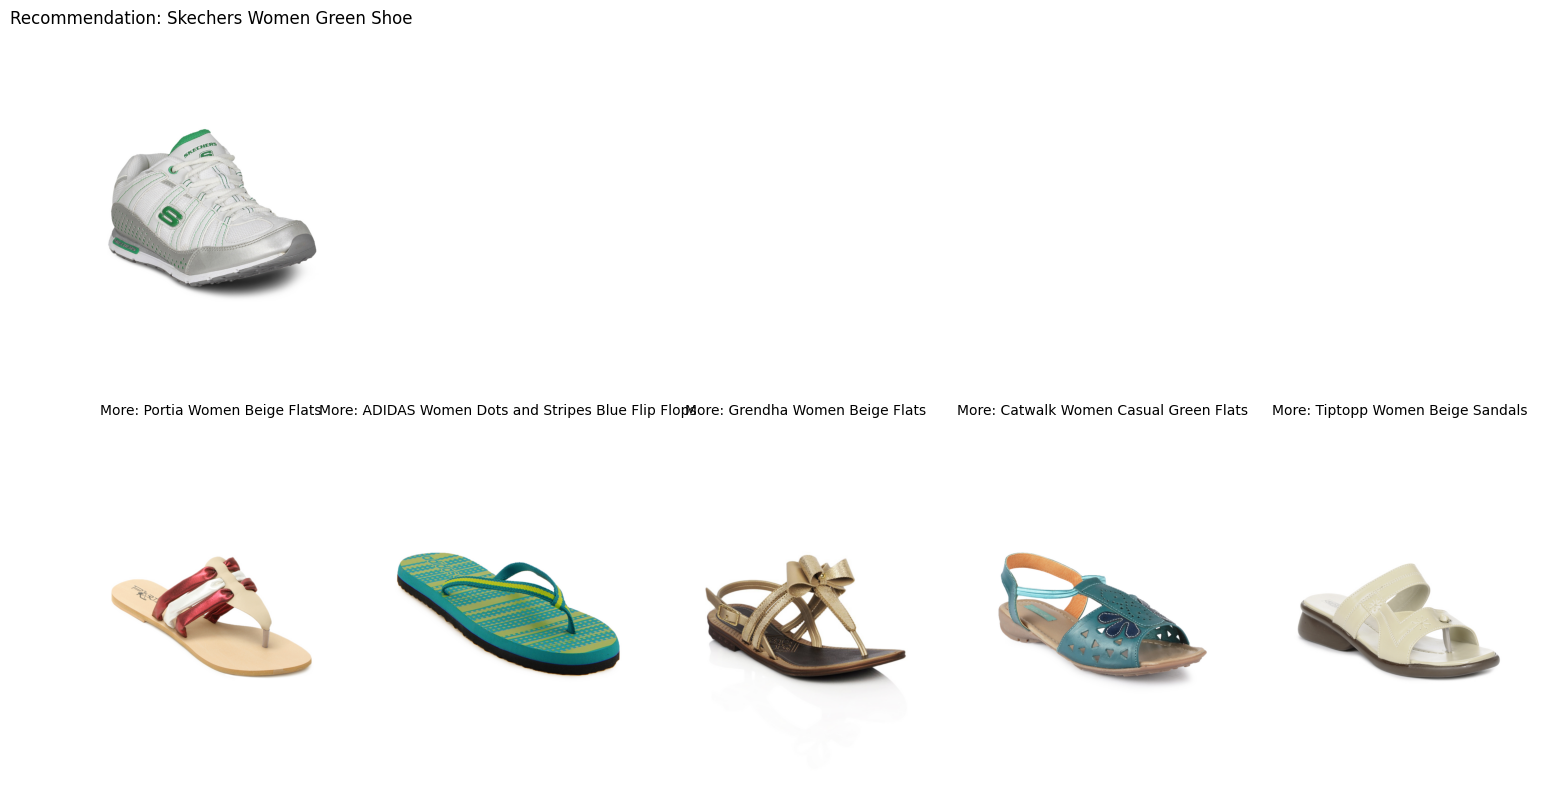

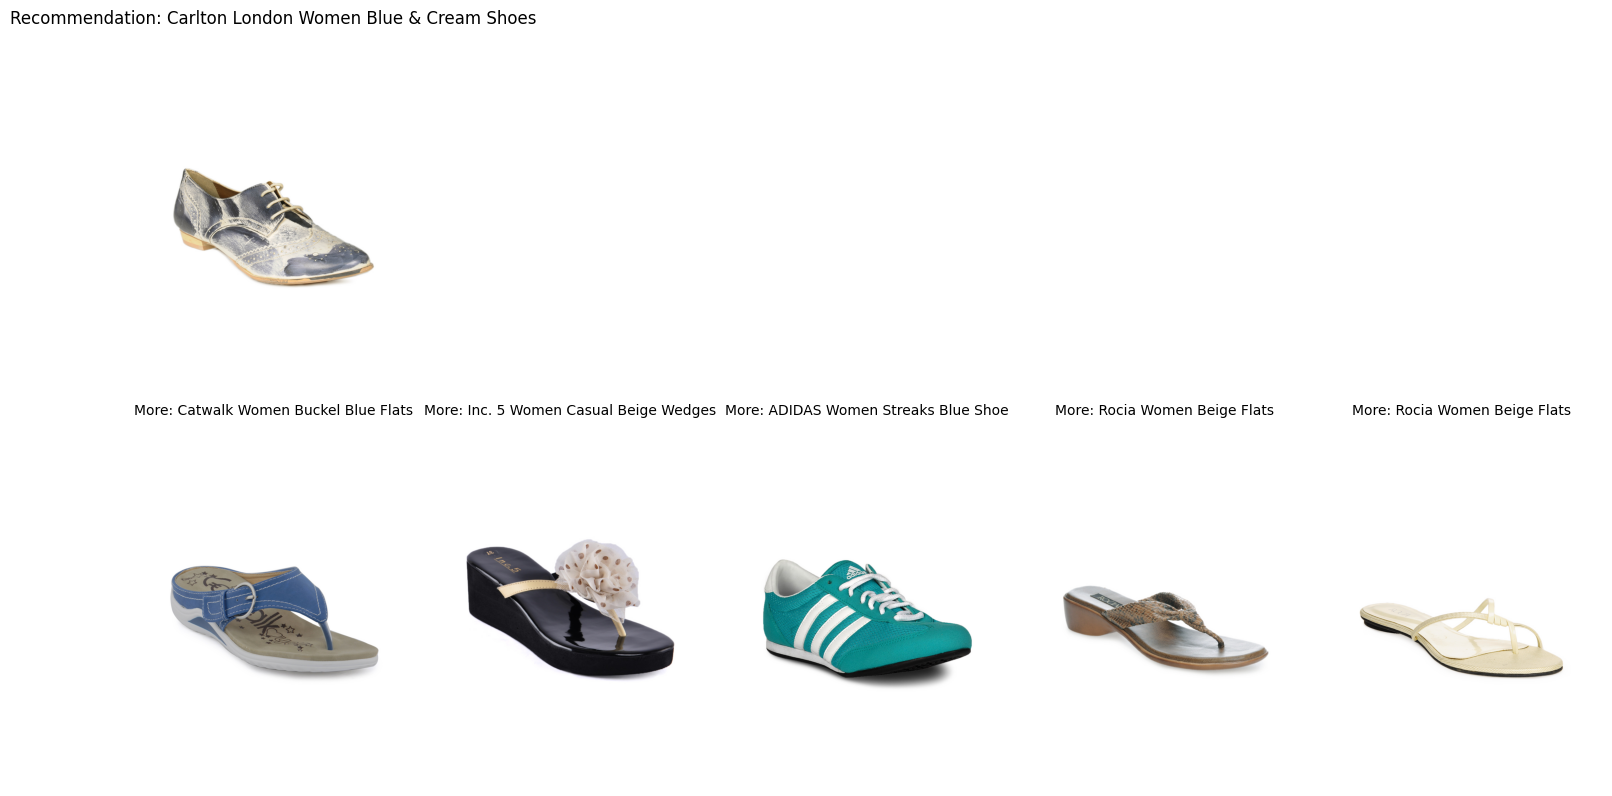

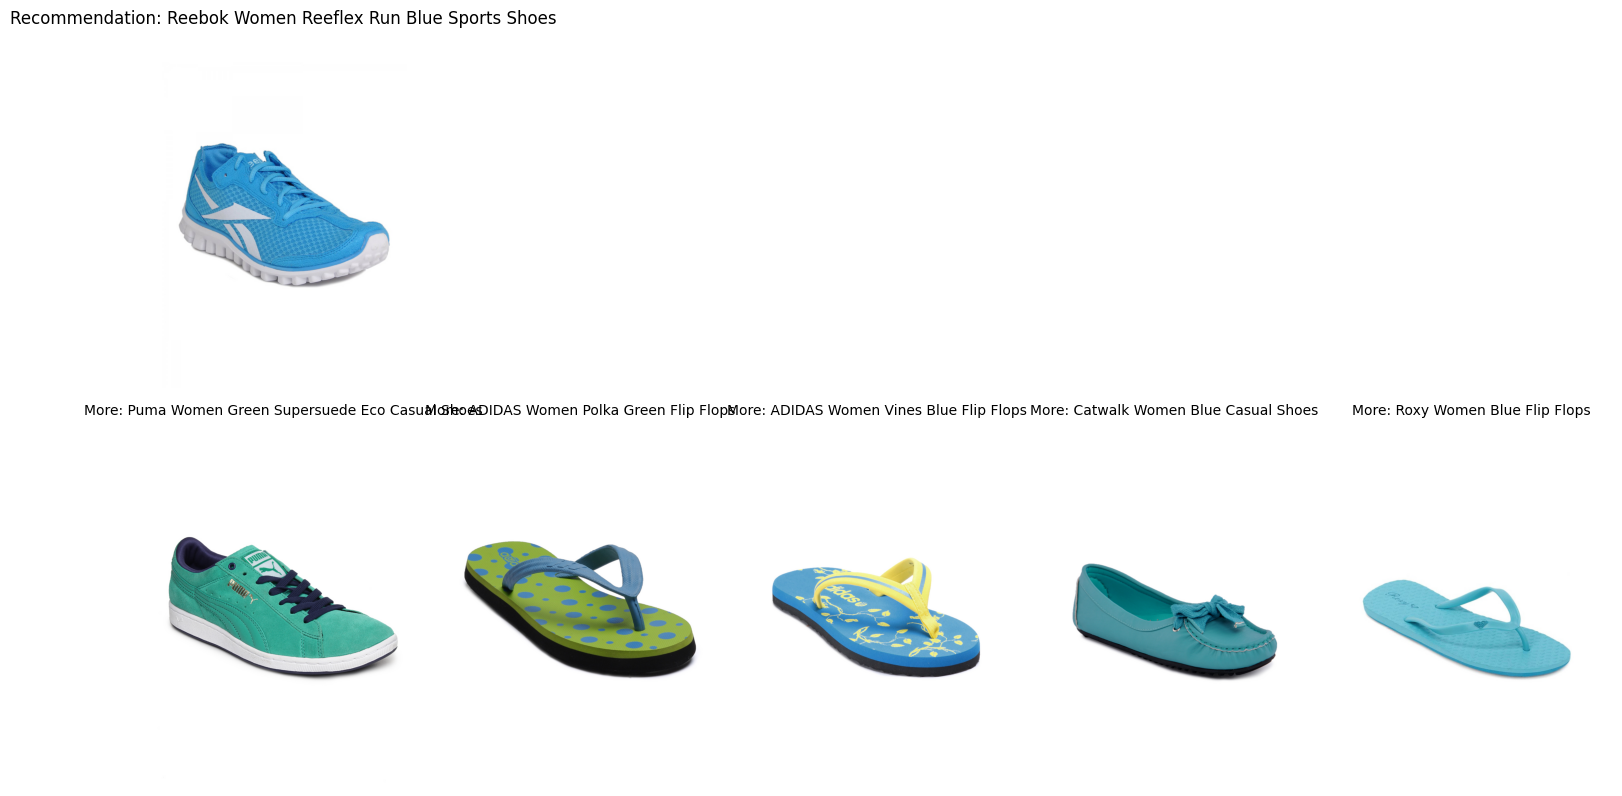

In [6]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import os

# Caching mechanism for images to avoid repeated HTTP requests
image_cache = {}

def get_image_from_url(image_url):
    if image_url not in image_cache:
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content))
        image_cache[image_url] = img
    return image_cache[image_url]

def show_recommendations_with_grid(recommendations, image_dir, data, top_n=5):
    for master_category, items in recommendations.items():
        print(f"Master Category: {master_category}")
        if isinstance(items, str):
            print(items)
            continue
        
        for rec in items:
            input_image = rec['recommended_items']
            recommended_images = rec['more_recommended_items']
            
            # Get productDisplayName for the input image
            input_display_name = data[data['image'] == input_image]['productDisplayName'].values[0]
            
            # Prepare the figure
            num_recommendations = len(recommended_images)
            num_columns = max(num_recommendations, 1)
            fig, axes = plt.subplots(2, num_columns, figsize=(15, 8))
            
            # Show the main recommended image (Recommendation)
            input_image_url = f"{image_dir}{input_image}"
            img = get_image_from_url(input_image_url)
            axes[0, 0].imshow(img)
            axes[0, 0].axis('off')
            axes[0, 0].set_title(f"Recommendation: {input_display_name}", fontsize=12)
            
            # Hide unused axes in the top row
            for ax in axes[0, 1:]:
                ax.axis('off')
            
            # Show more recommendations in the second row
            for i, recommended_image in enumerate(recommended_images):
                recommended_image_url = f"{image_dir}{recommended_image}"
                recommended_display_name = data[data['image'] == recommended_image]['productDisplayName'].values[0]
                img = get_image_from_url(recommended_image_url)
                axes[1, i].imshow(img)
                axes[1, i].axis('off')
                axes[1, i].set_title(f"More: {recommended_display_name}", fontsize=10)
            
            # Hide any unused axes in the second row
            for ax in axes[1, len(recommended_images):]:
                ax.axis('off')
            
            plt.tight_layout()
            plt.show()

# Example usage
show_recommendations_with_grid(recommendations_by_category, image_directory, data)
